## Computergestützte Methoden der Finanzmathematik
### Value at Risk Schätzer und Backtesting
### Prof.Dr. Christina Erlwein-Sayer - Dr. Alla Petukhina
#### Thi Thuy Le - S0564314 - Quy Quynh Hoa Vu - S0569147


In [78]:
!pip install investpy prettytable

In [79]:
!pip install -U matplotlib

In [80]:
import investpy
import pandas as pd
from scipy.stats import norm, mstats
import numpy as np
import matplotlib.pyplot as plt

In [81]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 7)

# Value-at-Risk Estimation and Backtesting

In diesem Projekt zeigen wir, wie man den Value-at-Risk (VaR) mit drei Methoden schätzt und Backtesting durchf ̈uhrt. Die drei Methoden sind:

- Normal distribution

- Historical simulation

- Exponential weighted moving average (EWMA)



## Datensätze importieren and Test Window definieren


Wir importieren Datensätze. Datensätze verwendete Wert stammt aus einer Zeitreihe des S&P-Index von 01.01.2011 bis 31.12.2021.

In [117]:
sp_index = investpy.get_index_historical_data(
    index="S&P 500", country="United States", from_date="01/01/2011", to_date="31/12/2021"
)

Wir betrachten die Daten vom S&P Index im Zeitraum von 01.01.2011 bis 31.12.2021

In [116]:
sp_index

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2011-01-03,1257.62,1276.17,1257.62,1271.87,0,USD
2011-01-04,1272.95,1274.12,1262.66,1270.20,0,USD
2011-01-05,1268.78,1277.63,1265.36,1276.56,0,USD
2011-01-06,1276.29,1278.17,1270.43,1273.85,0,USD
2011-01-07,1274.41,1276.83,1261.70,1271.50,0,USD
...,...,...,...,...,...,...
2021-12-27,4733.99,4791.49,4733.99,4791.19,0,USD
2021-12-28,4795.49,4807.02,4780.04,4786.36,0,USD
2021-12-29,4788.64,4804.06,4778.08,4793.06,0,USD


In [84]:
sp_index.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2769 entries, 2011-01-03 to 2021-12-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Open      2769 non-null   float64
 1   High      2769 non-null   float64
 2   Low       2769 non-null   float64
 3   Close     2769 non-null   float64
 4   Volume    2769 non-null   int64  
 5   Currency  2769 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 151.4+ KB


Die Daten haben 2769 Zeilen und 6 Spalten

Auf den ersten Blick gibt es keinen Missing Values

In [85]:
sp_index.isnull()

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2011-01-03,False,False,False,False,False,False
2011-01-04,False,False,False,False,False,False
2011-01-05,False,False,False,False,False,False
2011-01-06,False,False,False,False,False,False
2011-01-07,False,False,False,False,False,False
...,...,...,...,...,...,...
2021-12-27,False,False,False,False,False,False
2021-12-28,False,False,False,False,False,False
2021-12-29,False,False,False,False,False,False


In [86]:
sp_index.isnull().sum()

Open        0
High        0
Low         0
Close       0
Volume      0
Currency    0
dtype: int64

In [87]:
VaRExample = sp_index[["Close"]]
VaRExample.index = pd.to_datetime(VaRExample.index)

In [88]:
def tick2ret(data):
    return data.pct_change(1)

In [89]:
Returns = tick2ret(VaRExample)
# Returns = Returns['Close'].to_list()
DateReturns = Returns.index
SampleSize = len(Returns)

Wir definieren das Schätzungsfenster als 250 Tage. Das Testfenster beginnt mit dem ersten Tag des Jahres 2012.

In [90]:
TestWindowStart = DateReturns.get_loc("2012").start
TestWindow = list(range(TestWindowStart, SampleSize + 1))
EstimationWindowSize = 250

Diese Werte bedeuten, dass der Verlust mit einer Wahrscheinlichkeit von höchstens 5 % bzw. 1 % liegt.

In [91]:
pVaR = [0.05, 0.01]

## Berechnungsmodelle des Value-at-Risk



### Normal Distribution Method

Bei der Methode der Normalverteilung nehmen wir an, dass die Gewinne und Verluste des Portfolios normal verteilt sind. Berechnen Sie unter dieser Annahme den VaR, indem Sie den z-Score für jedes Konfidenzniveau mit der Standardabweichung der Renditen multiplizieren. Da beim VaR-Backtesting die Daten rückwirkend betrachtet werden, wird der VaR "heute" auf der Grundlage der Renditewerte der letzten N = 250 Tage berechnet, die zum "heute" führen, ihn aber nicht einschließen.

Die Methode der Normalverteilung wird auch als parametrischer VaR bezeichnet, da ihre Schätzung die Berechnung eines Parameters für die Standardabweichung der Renditen beinhaltet. Der Vorteil der Normalverteilungsmethode ist ihre Einfachheit. Die Schwäche der Normalverteilungsmethode ist jedoch die Annahme, dass die Renditen normalverteilt sind. Eine andere Bezeichnung für die Normalverteilungsmethode ist Varianz-Kovarianz-Ansatz.

In [92]:
Zscore = norm.ppf(pVaR)
Normal95 = np.zeros(len(TestWindow) + 1).reshape(-1, 1)
Normal99 = np.zeros(len(TestWindow) + 1).reshape(-1, 1)


for t in TestWindow:
    i = t - TestWindowStart + 1
    EstimationWindow = list(range(t - EstimationWindowSize, t - 1))

    Sigma = np.std(Returns[EstimationWindow[0] : EstimationWindow[-1] + 1])
    Normal95[i] = -Zscore[0] * Sigma
    Normal99[i] = -Zscore[1] * Sigma;

Text(0.5, 1.0, 'VaR Estimation Using the Normal Distribution Method')

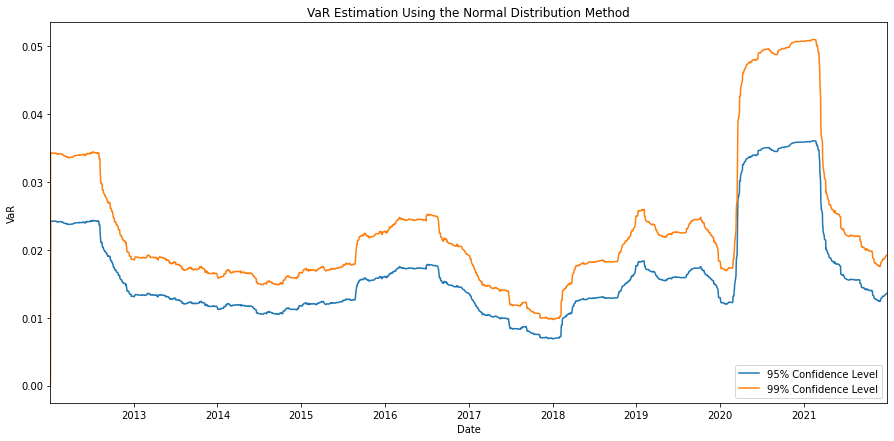

In [93]:
plt.plot(DateReturns[TestWindow[:-1]], Normal95[:-2], label="95% Confidence Level")
plt.plot(DateReturns[TestWindow[:-1]], Normal99[:-2], label="99% Confidence Level")
plt.xlim(DateReturns[TestWindow[0]], DateReturns[TestWindow[-2]])
plt.xlabel("Date")
plt.ylabel("VaR")
plt.legend(loc=4)
plt.title("VaR Estimation Using the Normal Distribution Method")

## Historical Simulation Method

Im Gegensatz zur Normalverteilungsmethode ist die historische Simulation (HS) eine nichtparametrische Methode. Sie geht nicht von einer bestimmten Verteilung der Vermögenserträge aus. Die historische Simulation prognostiziert das Risiko, indem sie davon ausgeht, dass die Gewinne und Verluste der Vergangenheit als Verteilung der Gewinne und Verluste für die nächste Renditeperiode verwendet werden können. Der VaR "heute" wird als das p th-Quantil der letzten N Renditen vor "heute" berechnet.

In [94]:
Historical95 = np.zeros(len(TestWindow) + 1).reshape(-1, 1)
Historical99 = np.zeros(len(TestWindow) + 1).reshape(-1, 1)


for t in TestWindow:
    i = t - TestWindowStart + 1
    EstimationWindow = list(range(t - EstimationWindowSize, t - 1))

    X = Returns[EstimationWindow[0] : EstimationWindow[-1] + 1]
    Historical95[i] = -mstats.mquantiles(X, pVaR[0], 0.5, 0.5)
    Historical99[i] = -mstats.mquantiles(X, pVaR[1], 0.5, 0.5);

Text(0.5, 1.0, 'VaR Estimation Using the Historical Simulation Method')

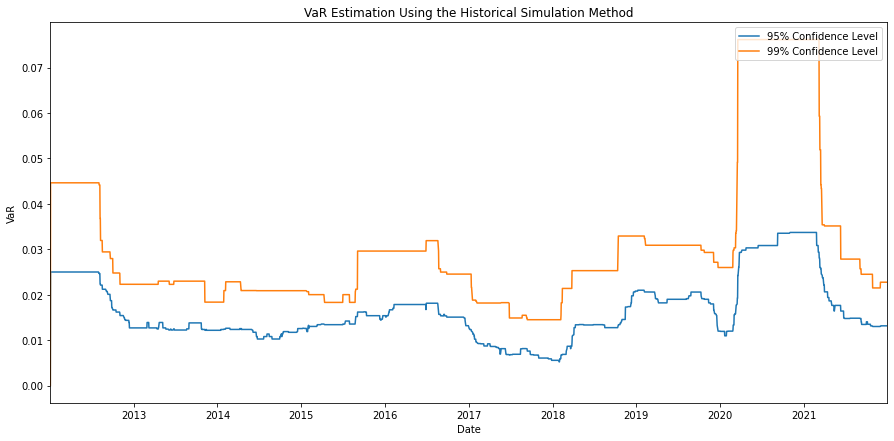

In [95]:
plt.plot(DateReturns[TestWindow[:-1]], Historical95[:-2], label="95% Confidence Level")
plt.plot(DateReturns[TestWindow[:-1]], Historical99[:-2], label="99% Confidence Level")
plt.xlim(DateReturns[TestWindow[0]], DateReturns[TestWindow[-2]])
plt.xlabel("Date")
plt.ylabel("VaR")
plt.legend(loc=1)
plt.title("VaR Estimation Using the Historical Simulation Method")

Berechnung des VaR mit der Methode des exponentiell gewichteten gleitenden Durchschnitts (EWMA) Die vorangehende Abbildung zeigt, dass die historische Simulationskurve ein stückweise konstantes Profil aufweist. Der Grund dafür ist, dass sich die Quantile mehrere Tage lang nicht ändern, bis extreme Ereignisse eintreten. Daher reagiert die historische Simulationsmethode nur langsam auf Änderungen der Volatilität.


### Exponential Weighted Moving Average Method (EWMA)
Berechnung des VaR mit der Methode des exponentiell gewichteten gleitenden Durchschnitts (EWMA) Die vorangehende Abbildung zeigt, dass die historische Simulationskurve ein stückweise konstantes Profil aufweist. Der Grund dafür ist, dass sich die Quantile mehrere Tage lang nicht ändern, bis extreme Ereignisse eintreten. Daher reagiert die historische Simulationsmethode nur langsam auf Änderungen der Volatilität.

In [96]:
Returns = list(Returns["Close"])
Lambda = 0.94
Sigma2 = np.zeros(SampleSize + 1).reshape(-1, 1)
Sigma2[0] = Returns[0] ** 2

for i in range(2, TestWindowStart):
    Sigma2[i] = (1 - Lambda) * Returns[i - 1] ** 2 + Lambda * Sigma2[i - 1];
    # print(Sigma2[i])

In [97]:
Zscore = norm.ppf(pVaR)
EWMA95 = np.zeros(len(TestWindow) + 1).reshape(-1, 1)
EWMA99 = np.zeros(len(TestWindow) + 1).reshape(-1, 1)

for t in TestWindow:
    k = t - TestWindowStart + 1
    Sigma2[t] = (1 - Lambda) * Returns[t - 1] ** 2 + Lambda * Sigma2[t - 1]
    Sigma = (Sigma2[t]) ** (1 / 2)
    # print(Sigma)
    EWMA95[k] = -Zscore[0] * Sigma
    EWMA99[k] = -Zscore[1] * Sigma;

Text(0.5, 1.0, 'VaR Estimation Using the EWMA Method')

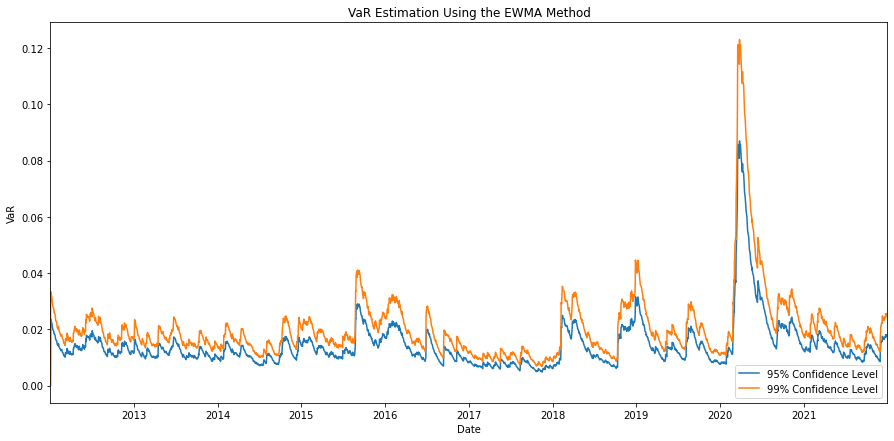

In [98]:
plt.plot(DateReturns[TestWindow[:-1]], EWMA95[:-2], label="95% Confidence Level")
plt.plot(DateReturns[TestWindow[:-1]], EWMA99[:-2], label="99% Confidence Level")
plt.xlim(DateReturns[TestWindow[0]], DateReturns[TestWindow[-2]])
plt.xlabel("Date")
plt.ylabel("VaR")
plt.legend(loc=4)
plt.title("VaR Estimation Using the EWMA Method")

## VaR Backtesting

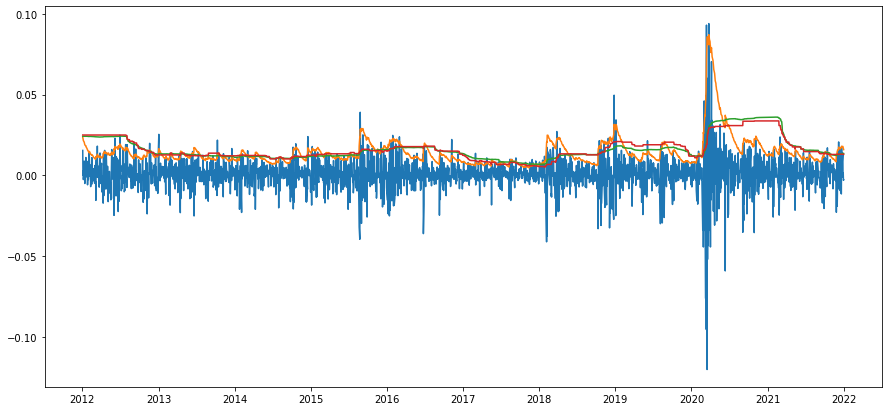

In [99]:
ReturnsTest = Returns[TestWindow[0] : TestWindow[-1]]
# ReturnsTest = [i + 0.025 for i in ReturnsTest]
DatesTest = DateReturns[TestWindow[:-1]]
# plot(DatesTest,[ReturnsTest -Normal95 -Historical95 -EWMA95])

plt.plot(DatesTest, ReturnsTest, label="95% Confidence Level")
plt.plot(DatesTest, EWMA95[2:], label="95% Confidence Level")
plt.plot(DatesTest, Normal95[2:], label="95% Confidence Level")
plt.plot(DatesTest, Historical95[2:], label="95% Confidence Level")


# ylabel('VaR')
# xlabel('Date')
# legend({'Returns','Normal','Historical','EWMA'},'Location','Best')
# title('Comparison of returns and VaR at 95% for different models')

Um zu verdeutlichen, wie unterschiedlich die verschiedenen Ansätze auf veränderte Marktbedingungen reagieren, können Sie die Zeitreihen vergrößern, in denen es zu einer großen und plötzlichen Veränderung des Renditewerts kommt. Zum Beispiel im August 2020.

In [100]:
start = DatesTest.get_loc("2020-02-05")
end = DatesTest.get_loc("2020-04-28")
start, end

(2035, 2092)

In [101]:
def getLessIndex(listA, listB):
    res = []
    for i in range(len(listA)):
        if listA[i] < listB[i]:
            res.append(i)
    return res

(18297.0, 18376.0)

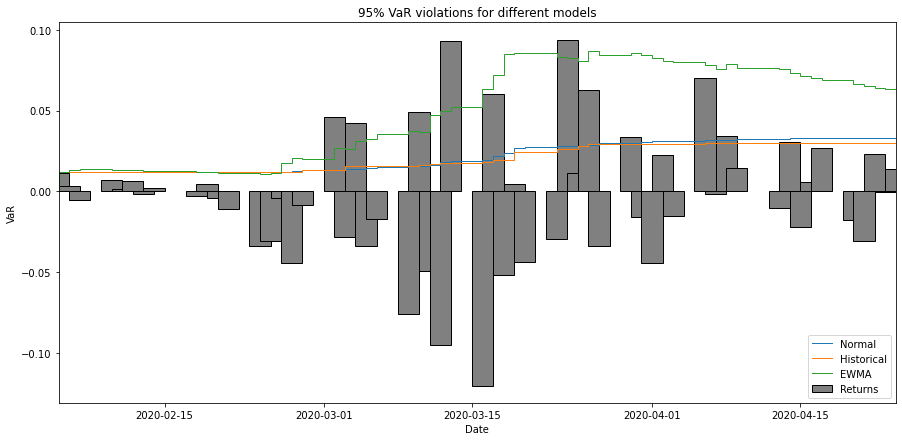

In [102]:
ZoomInd = list(range(start, end))

VaRData = [Normal95[ZoomInd], Historical95[ZoomInd], EWMA95[ZoomInd]]

VaRFormat = ["-", "--", "-."]
VaRLegend = ["Normal", "Historical", "EWMA"]


D = DatesTest[ZoomInd[0] : ZoomInd[-1]]
R = ReturnsTest[ZoomInd[0] : ZoomInd[-1]]

N = Normal95[ZoomInd[0] : ZoomInd[-1]]
H = Historical95[ZoomInd[0] : ZoomInd[-1]]
E = EWMA95[ZoomInd[0] : ZoomInd[-1]]


IndN95 = getLessIndex(R, -N)
IndHS95 = getLessIndex(R, -H)
IndEWMA95 = getLessIndex(R, -E)


# figure;
plt.bar(D, R, 2, color="gray", edgecolor="black", label="Returns")

# hold on
for i in range(len(VaRData)):
    plt.stairs(VaRData[i][:-2, 0], D, label=VaRLegend[i])
# end
plt.ylabel("VaR")
plt.xlabel("Date")
plt.legend(loc=4)
plt.title("95% VaR violations for different models")


plt.xlim([D[0], D[-1]])

Ein VaR-Ausfall oder eine VaR-Verletzung liegt vor, wenn die Renditen einen positiven VaR aufweisen. Eine genauere Betrachtung um den 10. März bis zum 17. März herum zeigt einen deutlichen Einbruch der Renditen. 

An den Tagen ab dem 10. März folgt der EWMA dem Trend der Renditen enger und genauer. 

In [103]:
from varbacktests import VaRBackTest

In [104]:
vbt = VaRBackTest(ReturnsTest , varData = [Normal95, Normal99] , \
          varID = ['Normal95','Normal99'], varLevel=[0.95, 0.99])

In [105]:
vbt.summary()

+---------------+----------+----------+-------------------+--------------+----------+--------------------+--------------------+--------------+---------+
|   PorfolioID  |  VarID   | VarLevel | ObservationsLevel | Observations | Failures |      Excepted      |       Ratio        | FirstFailure | Missing |
+---------------+----------+----------+-------------------+--------------+----------+--------------------+--------------------+--------------+---------+
| ['S&P Index'] | Normal95 |   0.95   |        0.95       |    2519.0    |  124.0   | 125.95000000000012 | 0.9845176657403722 |    104.0     |   0.0   |
| ['S&P Index'] | Normal99 |   0.99   |        0.99       |    2519.0    |   64.0   | 25.190000000000023 | 2.5406907502977347 |    213.0     |   0.0   |
+---------------+----------+----------+-------------------+--------------+----------+--------------------+--------------------+--------------+---------+


Der zusammenfassende Bericht zeigt, dass das beobachtete Niveau nahe genug an dem definierten VaR-Niveau liegt. Die 95%- und 99%-VaR-Niveaus haben höchstens (1-VaR_Level) x N erwartete Ausfälle, wobei N die Anzahl der Beobachtungen ist. Die Ausfallquote zeigt, dass das Normal95-VaR-Niveau innerhalb des Bereichs liegt, während das Normal99-VaR-Niveau ungenau ist und das Risiko unterprognostiziert. Um alle in varbacktest unterstützten Tests auszuführen, verwenden Sie runtests.

Das VaR-Backtesting mit acht verschiedenen Modellen wie Bin-, POF-, TL-, TUFF-, CC-, TBF-, CCI- und TBFI-Tests wurde angewendet.

In [106]:
vbt.runtests()

+-------------+----------+-----+--------+--------+--------+--------+--------+--------+--------+
| PortfolioID |  VarID   |  TL |  Bin   |  Pof   |  Tuff  |   CC   |  CCI   |  Tbfi  |  Tbf   |
+-------------+----------+-----+--------+--------+--------+--------+--------+--------+--------+
|  S&P Index  | Normal95 | red | reject | accept | reject | accept | accept | reject | reject |
|  S&P Index  | Normal99 | red | reject | reject | reject | accept | accept | reject | reject |
+-------------+----------+-----+--------+--------+--------+--------+--------+--------+--------+


In [107]:
vbt = VaRBackTest(ReturnsTest,[Normal95,Historical95,EWMA95,Normal99,Historical99, \
    EWMA99],portfolioID = 'S&P Index', varID = ['Normal95','Historical95','EWMA95', \
    'Normal99','Historical99','EWMA99'], varLevel = [0.95,0.95,0.95,0.99,0.99,0.99])
vbt.runtests()

+-------------+--------------+-----+--------+--------+--------+--------+--------+--------+--------+
| PortfolioID |    VarID     |  TL |  Bin   |  Pof   |  Tuff  |   CC   |  CCI   |  Tbfi  |  Tbf   |
+-------------+--------------+-----+--------+--------+--------+--------+--------+--------+--------+
|      S      |   Normal95   | red | reject | accept | reject | accept | accept | reject | reject |
|      S      | Historical95 | red | reject | accept | reject | accept | accept | reject | reject |
|      S      |    EWMA95    | red | reject | accept | reject | accept | accept | reject | reject |
|      S      |   Normal99   | red | reject | reject | reject | accept | accept | reject | reject |
|      S      | Historical99 | red | reject | accept | reject | accept | accept | reject | reject |
|      S      |    EWMA99    | red | reject | reject | reject | accept | accept | reject | reject |
+-------------+--------------+-----+--------+--------+--------+--------+--------+--------+--------+


In [108]:
start = DatesTest.get_loc("2020-01-02")
end = DatesTest.get_loc("2020-12-31")
start, end


vbt2020 = VaRBackTest(ReturnsTest[start:end],[Normal95[start:end],\
                                        Historical95[start:end], EWMA95[start:end]],\
                                       portfolioID="S&P, 2000",varID=['Normal','Historical','EWMA'], varLevel=[0.95,0.95,0.95])
vbt2020.runtests()

+-------------+------------+-----+--------+--------+--------+--------+--------+--------+--------+
| PortfolioID |   VarID    |  TL |  Bin   |  Pof   |  Tuff  |   CC   |  CCI   |  Tbfi  |  Tbf   |
+-------------+------------+-----+--------+--------+--------+--------+--------+--------+--------+
|      S      |   Normal   | red | reject | reject | accept | accept | accept | reject | reject |
|      S      | Historical | red | reject | reject | accept | accept | accept | reject | reject |
|      S      |    EWMA    | red | reject | accept | accept | accept | accept | reject | reject |
+-------------+------------+-----+--------+--------+--------+--------+--------+--------+--------+


In [109]:
start = DatesTest.get_loc("2021-01-04")
end = DatesTest.get_loc("2021-12-30")
start, end


vbt2021 = VaRBackTest(ReturnsTest[start:end],[Normal95[start:end],\
                                        Historical95[start:end], EWMA95[start:end]],\
                                       portfolioID="S&P, 2001",varID=['Normal','Historical','EWMA'], varLevel=[0.95,0.95,0.95])
vbt2021.runtests()

+-------------+------------+-----+--------+--------+--------+--------+--------+--------+--------+
| PortfolioID |   VarID    |  TL |  Bin   |  Pof   |  Tuff  |   CC   |  CCI   |  Tbfi  |  Tbf   |
+-------------+------------+-----+--------+--------+--------+--------+--------+--------+--------+
|      S      |   Normal   | red | reject | reject | reject | accept | accept | reject | reject |
|      S      | Historical | red | reject | reject | reject | accept | accept | reject | reject |
|      S      |    EWMA    | red | reject | accept | accept | accept | accept | accept | accept |
+-------------+------------+-----+--------+--------+--------+--------+--------+--------+--------+
